# 验证码数据处理


In [1]:
from PIL import Image
from keras import backend as K

import string
import random
import glob

import numpy as np
from tensorflow import gfile
import matplotlib.pyplot as plt


Using TensorFlow backend.


# 定义超参数和字符集


In [8]:
NUMBER = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
LOWERCASE = [c for c in string.ascii_lowercase]
UPPERCASE = [c for c in string.ascii_uppercase]

CAPTCHA_CHARSET = NUMBER # 验证字符集
CAPTCHA_LEN = 4 # 验证码长度
CAPTCHA_HEIGHT = 60 # 验证码高度
CAPTCHA_WIDTH = 160 # 验证码宽度

TRAIN_DATASET_SIZE = 5000 # 验证码数据集大小
TEST_DATASET_SIZE = 1000
TRAIN_DATA_DIR = '..\\data\\captcha\\train\\'
TEST_DATA_DIR = '..\\data\\captcha\\test\\'


# 读取前100张图片，通过文件名解析


In [12]:
image = []
text = []
count = 0
for fn in glob.glob(TRAIN_DATA_DIR + '*.png'):
    image.append(np.array(Image.open(fn)))
    text.append(fn.lstrip(TRAIN_DATA_DIR).rstrip('.png'))
    count += 1
    if count > 100:
        break
        

# 数据可视化


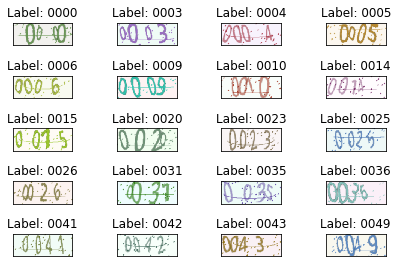

In [13]:
fig = plt.figure()
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.tight_layout()
    plt.imshow(image[i])
    plt.title("Label: {}".format(text[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()


# RGB转灰度图


In [14]:
def rgb2gray(img):
    # Y' = 0.299 R + 0.587 G + 0.114 B
    return np.dot(img[...,:3], [0.299, 0.587, 0.114])


In [22]:
image = np.array(image, dtype=np.float32)
image = rgb2gray(image)


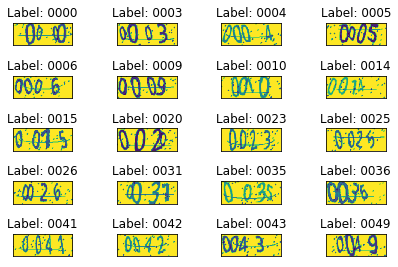

In [23]:
fig = plt.figure()
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.tight_layout()
    plt.imshow(image[i])
    plt.title("Label: {}".format(text[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()


# 数据规范化


In [24]:
image /= 255


# 适配keras图像数据格式


In [25]:
def fit_keras_channels(batch, rows=CAPTCHA_HEIGHT, cols=CAPTCHA_WIDTH):
    if K.image_data_format() == 'channels_first':
        batch = batch.reshape(batch.shape[0], 1, rows, cols)
        input_shape = (1, rows, cols)
    else:
        batch = batch.reshape(batch.shape[0], rows, cols, 1)
        input_shape = (rows, cols, 1)
    return batch, input_shape


In [26]:
image, input_shape = fit_keras_channels(image)
print(image.shape)
print(input_shape)


(101, 60, 160, 1)
(60, 160, 1)


# 对验证码中每个字符进行one-hot编码


In [27]:
def text2vec(text, length=CAPTCHA_LEN, charset=CAPTCHA_CHARSET):
    text_len = len(text)
    # validate
    if text_len != length:
        raise ValueError("Error: length of captcha should be {}, but got {}".format(length, text_len))
    
    # generate vec
    vec = np.zeros(length * len(charset))
    for i in range(length):
        # one-hot encode
        vec[charset.index(text[i]) + i*len(charset)] = 1
    return vec
